# SpecMod Tutorial Notebook

This notebook is intended to guide the user on how to: 

1. preprocess data for input to specmod
2. calculate spectra for modeling
3. model earthquake spectra (although it may still be used outside of earthquake sources)

## Pre Processing Module Imports
For the calculation of spectra, SpecMod requires two ObsPy streams:
1. signal
2. noise

It requires the user to cut their waveforms for their specific needs e.g. 'n' second P-phase window and 'x' seconds of window of pre-signal noise. 

It is up to you to cut them, some things to consider are:

1. what phase is required - P or S?
2. what is the most appropriate channel (e.g. vertical (Z) for P, transverse (T) or east/west (E/W) for S)
3. do you trust your picks - are they real / theoretical - what are rough errors?
4. how many seconds of noise do you want - pre or post signal?
5. do I need to add station specific time shifts - is one station off consistently?
6. do I need to make my windows slightly larger to account for errors in location/timing/picking?

I have provided some basic tools, but you do not need to use them at all if you don't want to! It is only required that each trace in each stream has the following metadata (set *MANUALLY*) in their .stats dictionary:

    1. tr.stats['dep'] = depth (kilometers)
    2. tr.stats['olon'] = origin longitude (decimal degrees)
    3. tr.stats['olat'] = origin latitude (decimal degrees)
    4. tr.stats['olat'] = origin latitude (decimal degrees)
    4. tr.stats['slon'] = station longitude (decimal degrees)
    5. tr.stats['slat'] = station latitude (decimal degrees)
    6. tr.stats['selv'] = station elevation (meters)
    7. tr.stats['repi'] = epicentral distance (source-reciever) (kilometers)
    6. tr.stats['rhyp'] = hypocentral distance (source-reciever) (kilometers)

In [1]:
import os
os.chdir("../")
import specmod.utils as ut
import specmod.PreProcess as pre
from obspy import read, read_inventory, UTCDateTime
os.chdir("Tutorial")

In [2]:
# Define parent directories
pdata = "Data/2019-08-26T07:30:47.0"
pinv = "MetaData/"

In [3]:
#ut.read_pyrocko() 

In [4]:
# Space for custom classes / functions


In [5]:
# Earthquake origin information
olat, olon, odep, otime = 53.784, -2.967, 2.1, UTCDateTime("2019-08-26T07:49:24.2")

In [6]:
# Read in our data (Vertical Channel)
st = read(os.path.join(pdata, '*HHZ*'), format='mseed')
# Read in the inventory (station XML file)
inv = read_inventory(os.path.join(pinv, "pnr_inventory.xml"), "stationxml")

In [7]:
# set the distances for the stream (required for theoreticals)
pre.set_stream_distance(st, olat, olon, odep, otime, inventory=inv, dtype="mseed")

# set the picks
pre.set_picks_from_pyrocko(st, os.path.join(pdata, "2019-08-26T07:30:47.000000.picks"))

# remove the traces with no p-pick 
for tr in st:
    try:
        tr.stats['p_time']
    except KeyError:
        st.remove(tr)

/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/obspy/core/inventory/network.py:324: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


In [8]:
# pre-process
st.detrend("linear")
st.detrend("demean")
st.taper(0.05)
st.remove_response(inv)

/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/obspy/core/inventory/network.py:254: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)


14 Trace(s) in Stream:
LV.L001..HHZ   | 2019-08-26T07:30:46.900000Z - 2019-08-26T07:30:53.900000Z | 100.0 Hz, 701 samples
LV.L002..HHZ   | 2019-08-26T07:30:48.050000Z - 2019-08-26T07:30:55.050000Z | 100.0 Hz, 701 samples
LV.L006..HHZ   | 2019-08-26T07:30:48.500000Z - 2019-08-26T07:30:55.500000Z | 100.0 Hz, 701 samples
LV.L007..HHZ   | 2019-08-26T07:30:49.410000Z - 2019-08-26T07:30:56.410000Z | 100.0 Hz, 701 samples
LV.L008..HHZ   | 2019-08-26T07:30:50.430000Z - 2019-08-26T07:30:57.430000Z | 100.0 Hz, 701 samples
LV.L009..HHZ   | 2019-08-26T07:30:47.040000Z - 2019-08-26T07:30:54.040000Z | 100.0 Hz, 701 samples
UR.AQ01.00.HHZ | 2019-08-26T07:30:50.800000Z - 2019-08-26T07:30:57.800000Z | 100.0 Hz, 701 samples
UR.AQ03.00.HHZ | 2019-08-26T07:30:47.235000Z - 2019-08-26T07:30:54.235000Z | 200.0 Hz, 1401 samples
UR.AQ04.00.HHZ | 2019-08-26T07:30:46.270000Z - 2019-08-26T07:30:53.270000Z | 200.0 Hz, 1401 samples
UR.AQ05.00.HHZ | 2019-08-26T07:30:46.615000Z - 2019-08-26T07:30:53.615000Z | 200.0 H

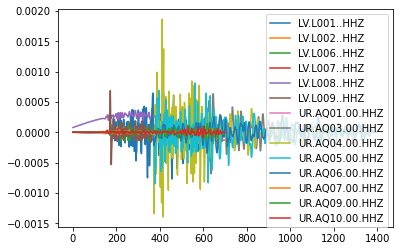

In [9]:
# quick sanity check
import matplotlib.pyplot as plt
for tr in st:
    plt.plot(tr.data, label=tr.id)
plt.legend()

In [10]:
st[0].stats

         network: LV
         station: L001
        location: 
         channel: HHZ
       starttime: 2019-08-26T07:30:46.900000Z
         endtime: 2019-08-26T07:30:53.900000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 701
           calib: 1.0
         _format: MSEED
         azimuth: 31.51024312303872
    back_azimuth: 211.54068284659363
             dep: 2.1
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 6, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 3072})
            olat: 53.784
            olon: -2.967
           otime: 2019-08-26T07:49:24.200000Z
          p_time: 2019-08-26T07:30:48.729390Z
      processing: ["ObsPy 1.2.1: detrend(options={}::type='linear')", "ObsPy 1.2.1: detrend(options={}::type='demean')", "ObsPy 1.2.1: taper(max_length=None::max_percentage=0.05::side='both'::type='hann')", "ObsPy 1.2.1: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x7fed9

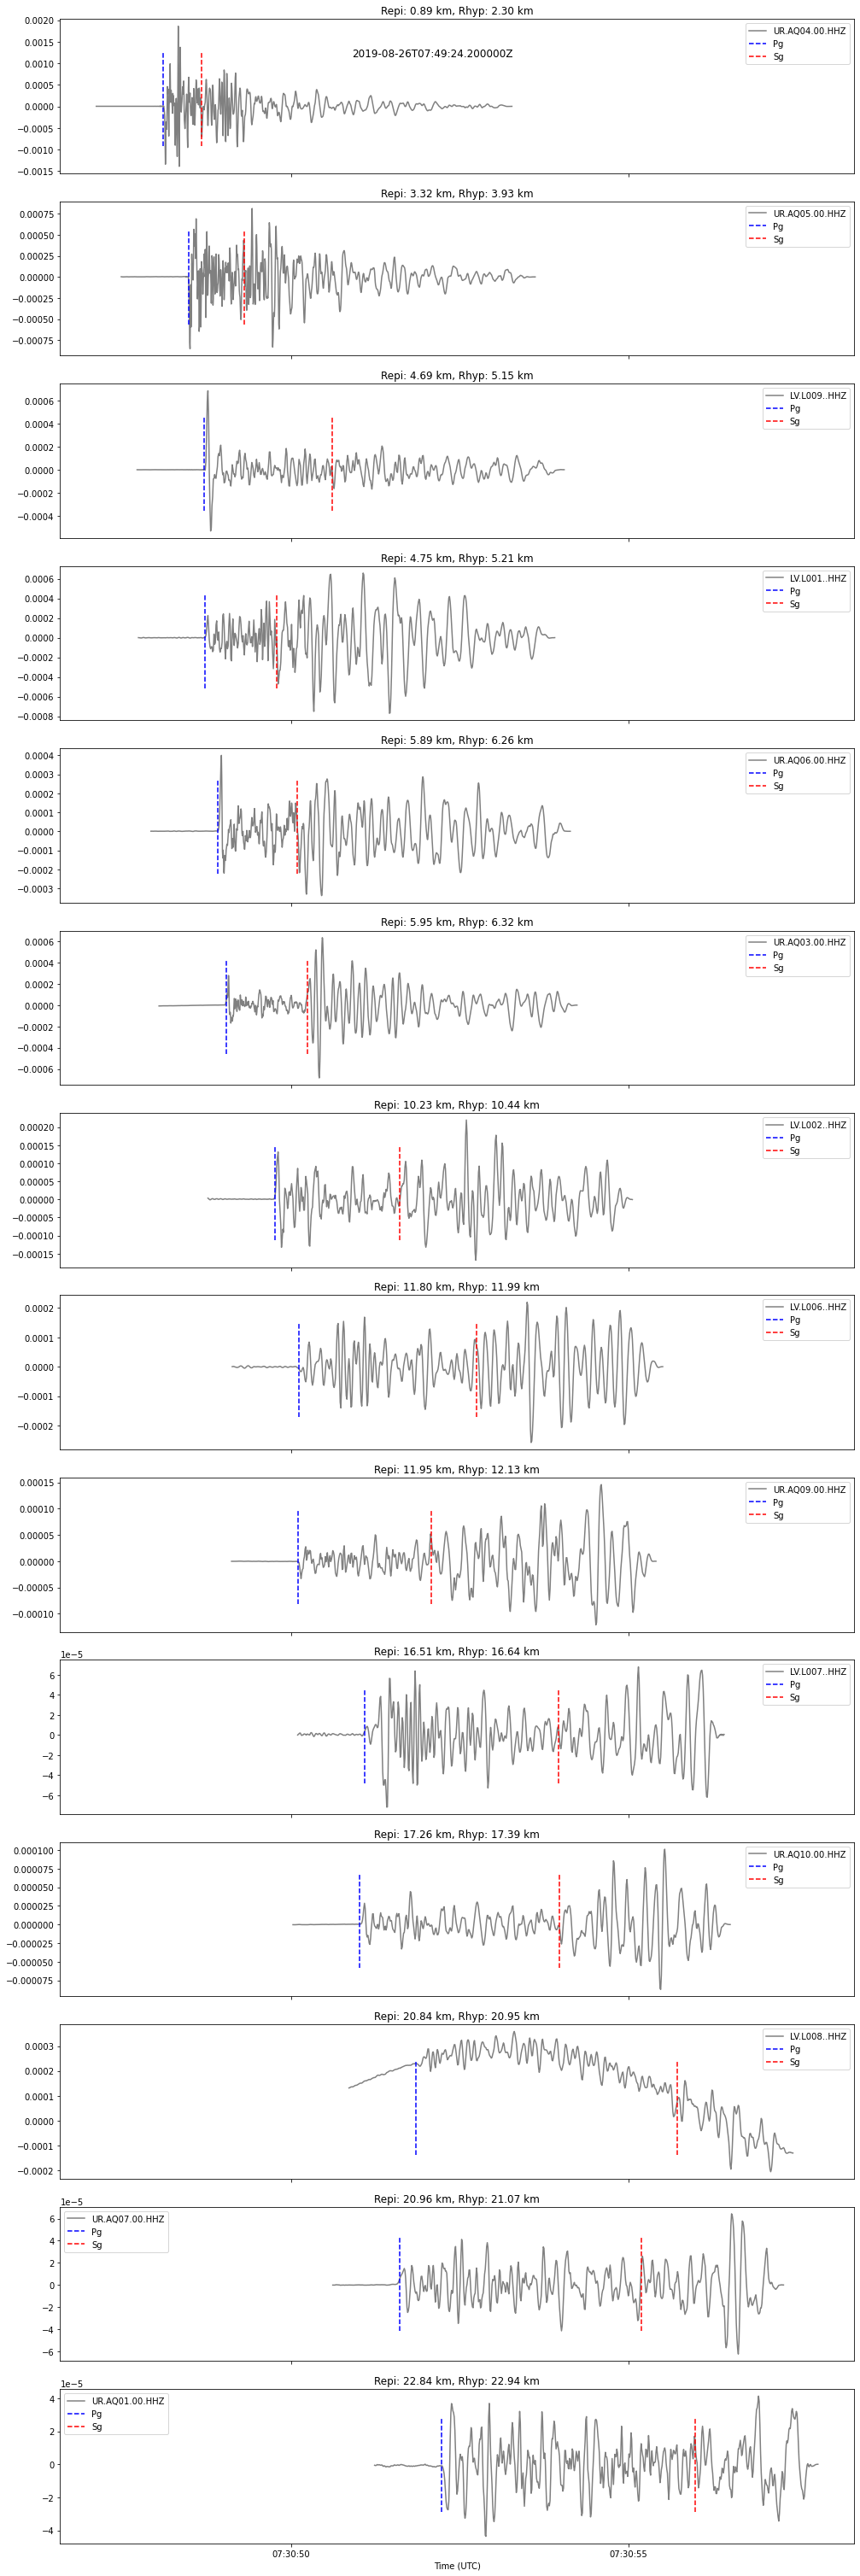

In [11]:
ut.plot_traces(st.copy(), plot_theoreticals=True, conv=1)

In [12]:
sig = pre.get_signal(st, pre.cut_p, bf=0, raf=0.8)
noise = pre.get_noise_p(st, sig, bf=1, bshift=0)

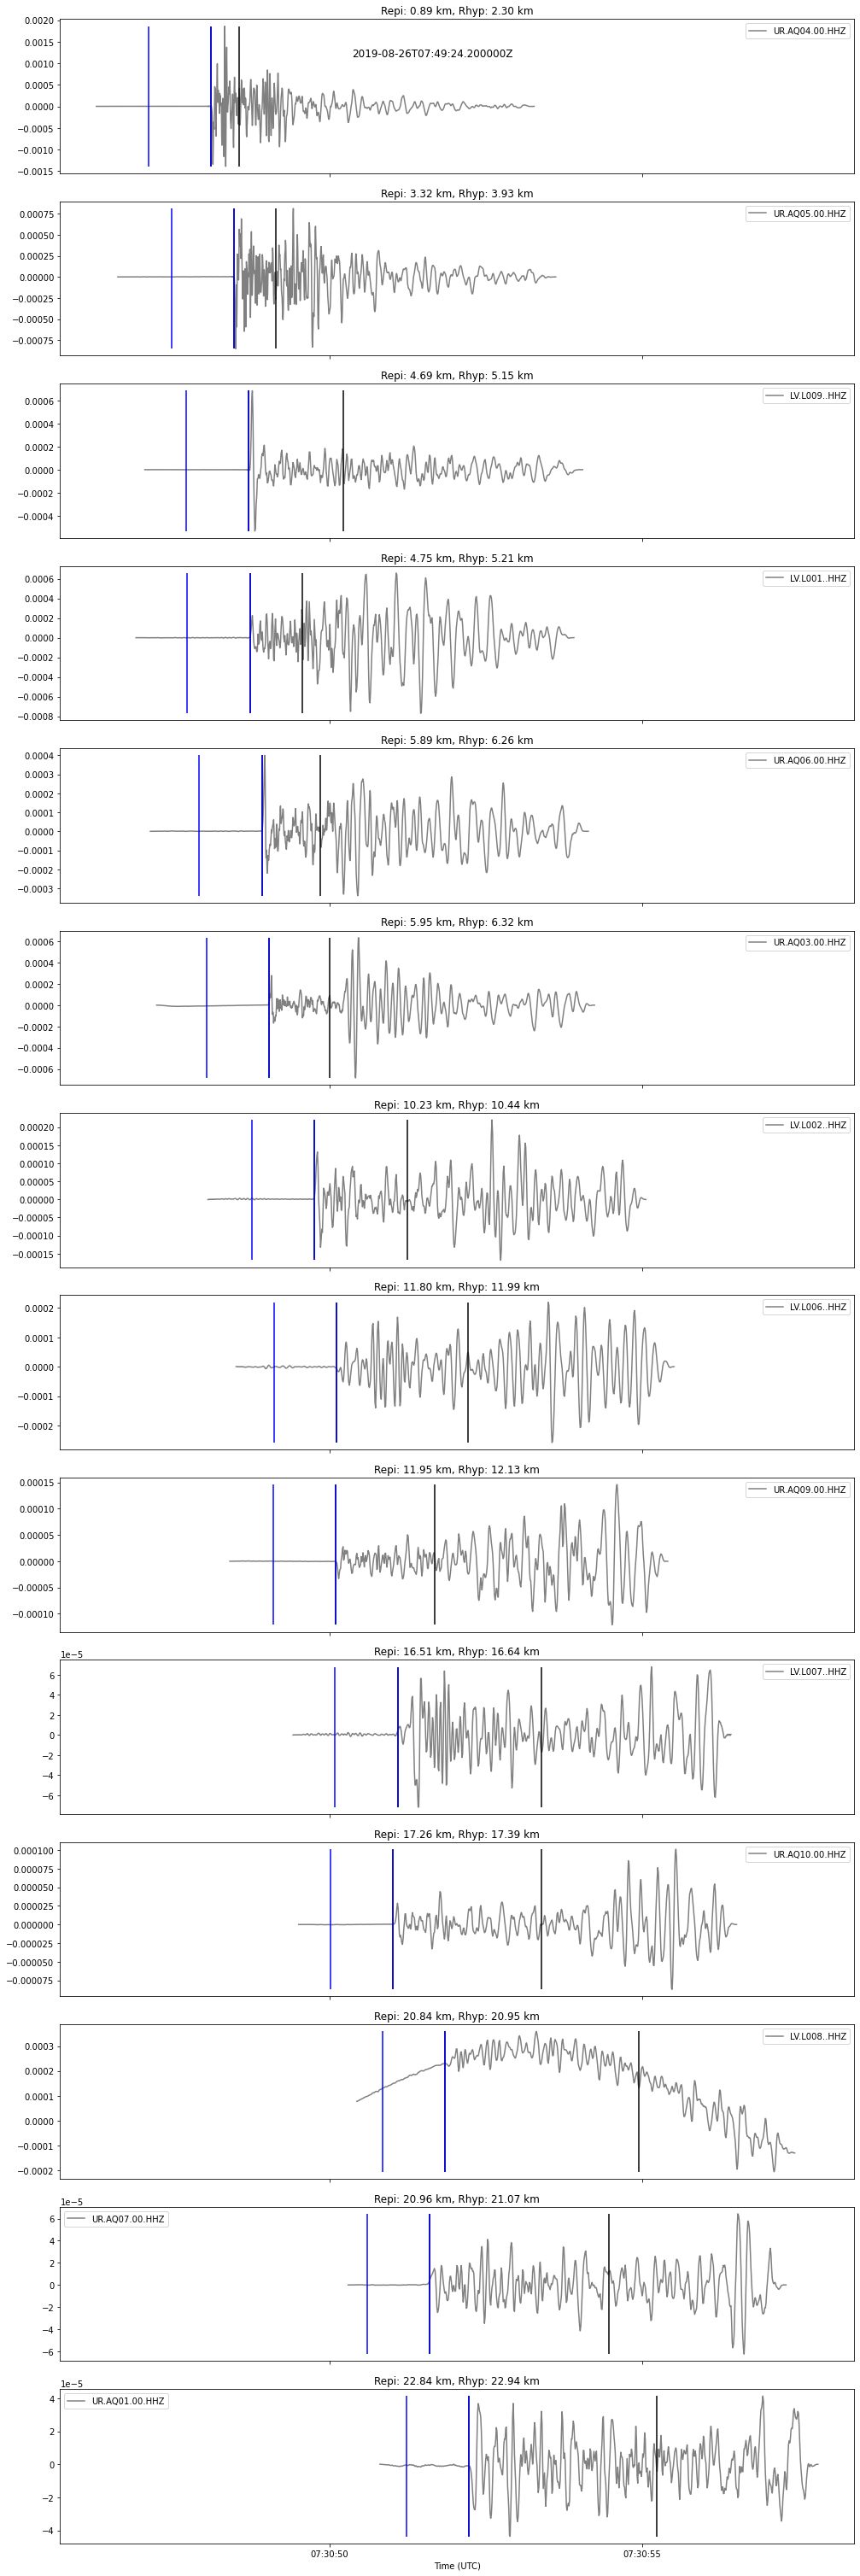

In [13]:
ut.plot_traces(st.copy(), plot_windows=True, conv=1, sig=sig, noise=noise)

# PART 2 - Process Spectra

Now the hard work is done, SpecMod will do the heavy lifting of spectral analysis for you.
This section will cover:
 1. creating spectra from the time series data you created earlier (ObsPy streams)
 2. saving the event spectra
 3. data manipulation (power spectra to amplitude, time integration/differentiation)
 5. visualisation

In [14]:
# import the spectral module to calculate spectra from signal and noise windows
os.chdir("../")
import specmod.Spectral as sp
os.chdir("Tutorial")

In [15]:
outpdir = "Spectra/"


In [16]:
spectra = sp.Spectra.from_streams(sig, noise, quadratic=True, number_of_tapers=5)

Doing LV.L001..HHZ
Didn't ever meet.
th1=-0.18800000000000014, th2=0
rotation failed for LV.L001..HHZ
Doing LV.L002..HHZ
Didn't ever meet.
th1=-0.1550000000000001, th2=0
rotation failed for LV.L002..HHZ
Doing LV.L006..HHZ
Didn't ever meet.
th1=-0.1290000000000001, th2=0
rotation failed for LV.L006..HHZ
Doing LV.L007..HHZ
already same level
th1=-0.1350000000000001, th2=0
rotation failed for LV.L007..HHZ
Doing LV.L008..HHZ
already same level
th1=-0.07900000000000006, th2=0
rotation failed for LV.L008..HHZ
Doing LV.L009..HHZ
Didn't ever meet.
th1=-0.2600000000000002, th2=0
rotation failed for LV.L009..HHZ
Doing UR.AQ01.00.HHZ
already same level
th1=-0.11000000000000008, th2=0
rotation failed for UR.AQ01.00.HHZ
Doing UR.AQ03.00.HHZ


/Users/jholt/Google Drive/UUSS/SpecMod/specmod/Spectral.py:145: RuntimeWarning: Mean of empty slice.
  a = 10**np.log10(amp[(freq>=bb)&(freq<=bf)]).mean()
/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


already same level
th1=-0.05200000000000004, th2=0
rotation failed for UR.AQ03.00.HHZ
Doing UR.AQ04.00.HHZ
Didn't ever meet.
th1=-0.33700000000000024, th2=0
rotation failed for UR.AQ04.00.HHZ
Doing UR.AQ05.00.HHZ
already same level
th1=-0.20100000000000015, th2=0
rotation failed for UR.AQ05.00.HHZ
Doing UR.AQ06.00.HHZ
Didn't ever meet.
th1=-0.2470000000000002, th2=0
rotation failed for UR.AQ06.00.HHZ
Doing UR.AQ07.00.HHZ
already same level
th1=-0.036000000000000025, th2=0
rotation failed for UR.AQ07.00.HHZ
Doing UR.AQ09.00.HHZ
already same level
th1=-0.08900000000000007, th2=0
rotation failed for UR.AQ09.00.HHZ
Doing UR.AQ10.00.HHZ
already same level
th1=-0.11500000000000009, th2=0
rotation failed for UR.AQ10.00.HHZ


/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


The spectra are computed using a multi-taper approach (Prieto, G. A., R. L. Parker, F. L. Vernon. (2009))

(<Figure size 1224x1800 with 15 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fed91b30990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fed714d33d0>], dtype=object))

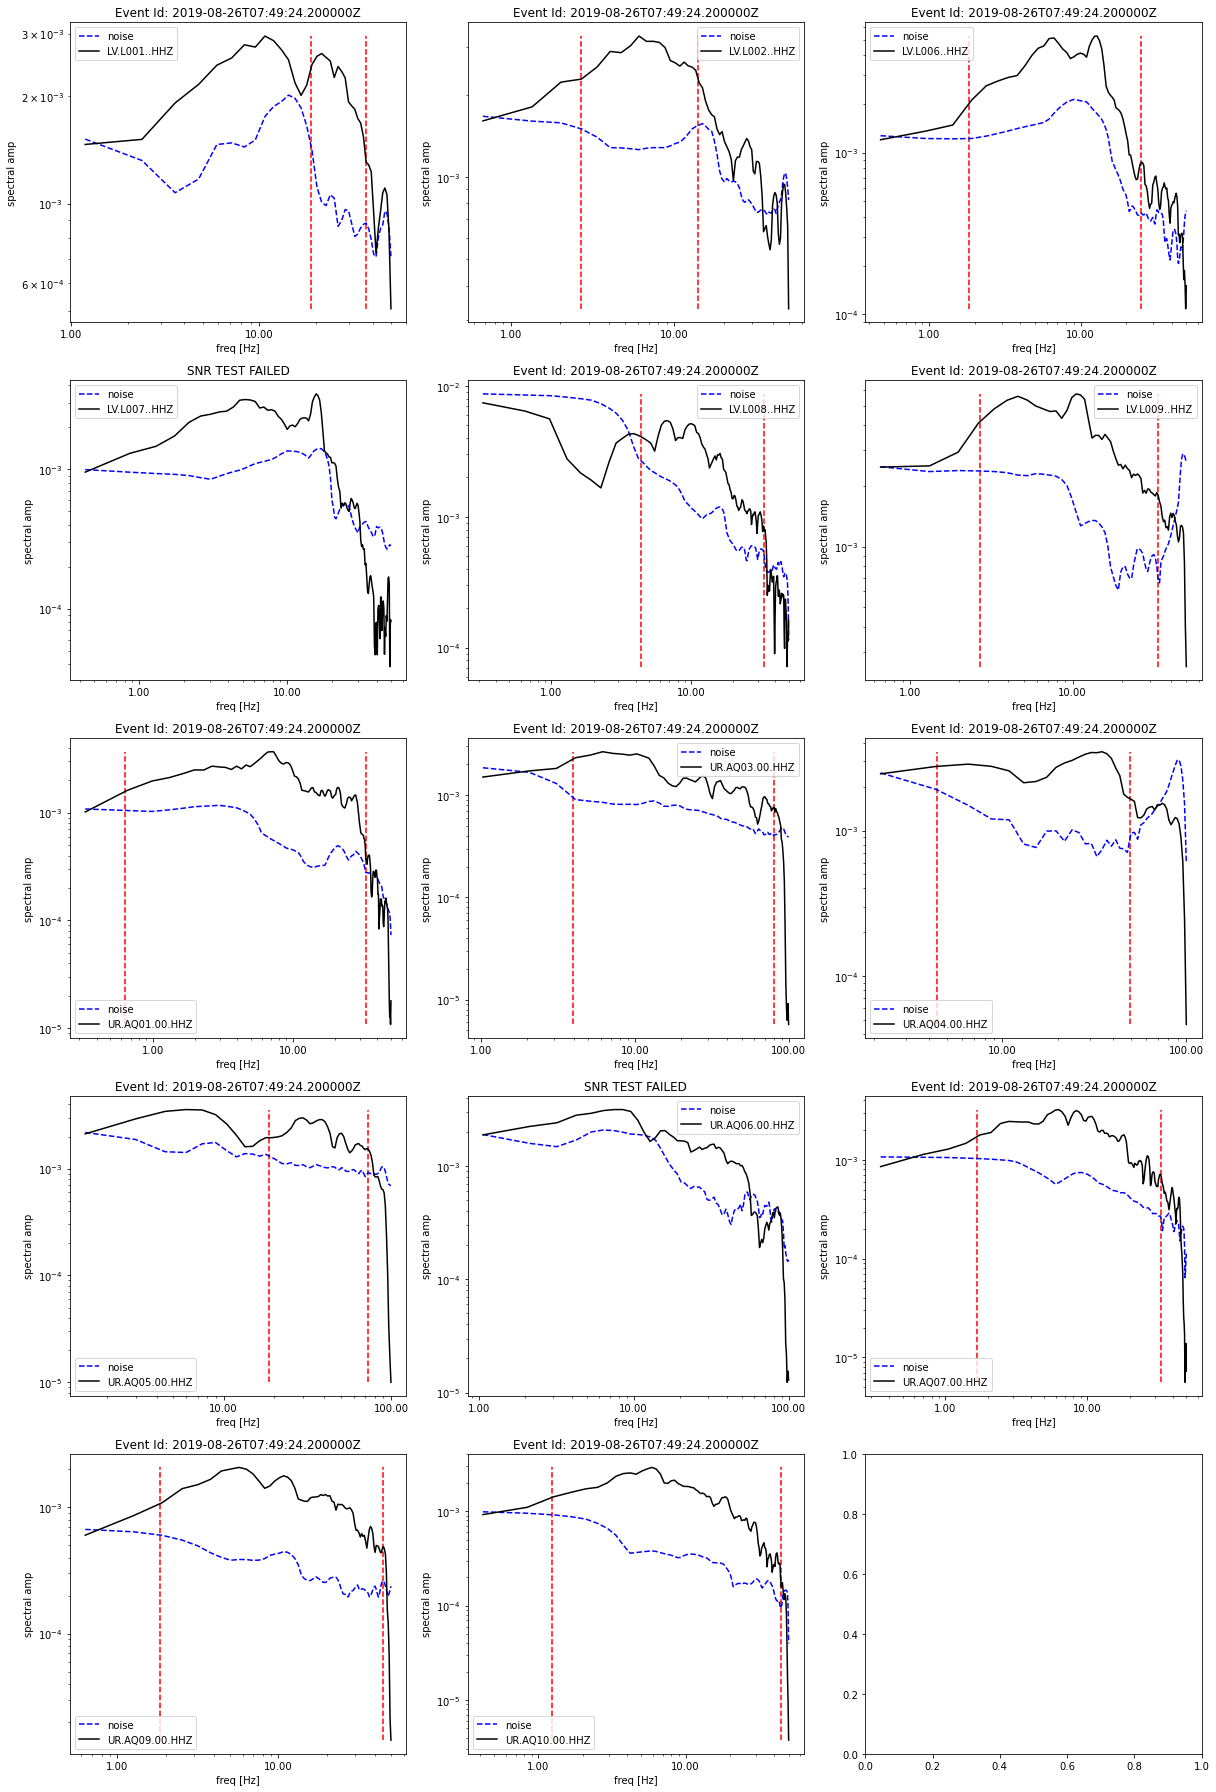

In [17]:
spectra.psd_to_amp() # change from PSD to AMP
spectra.quick_vis()

Note that the optimal signal bandwidth has been pre-calculated where signal-to-noise-ratio >= 3. *BEWARE FEATURE IS BUGGY SOMETIMES*

You can currently save the spectra out to a binary format called 'Pickle'.

In [18]:
# save the spectra 
spectra.write_spectra(os.path.join(outpdir, "2019-08-26T07:30:47.0"), spectra, method='pickle')
os.listdir(outpdir) # list the directory for proof!

['2019-08-26T07:30:47.0.spec', 'FlatFiles']

You MUST be careful when reading pickle files. Only read ones that you made or know who made them.

In [19]:
spectra = sp.Spectra.read_spectra(os.path.join(outpdir, "2019-08-26T07:30:47.0"+".spec"), method='pickle', skip_warning=True)

You can integrate to displacement easily. Assuming you removed the response to ground velocity, integrate once.

/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(<Figure size 1224x1800 with 15 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fed91b5fc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7feda1c1ddd0>], dtype=object))

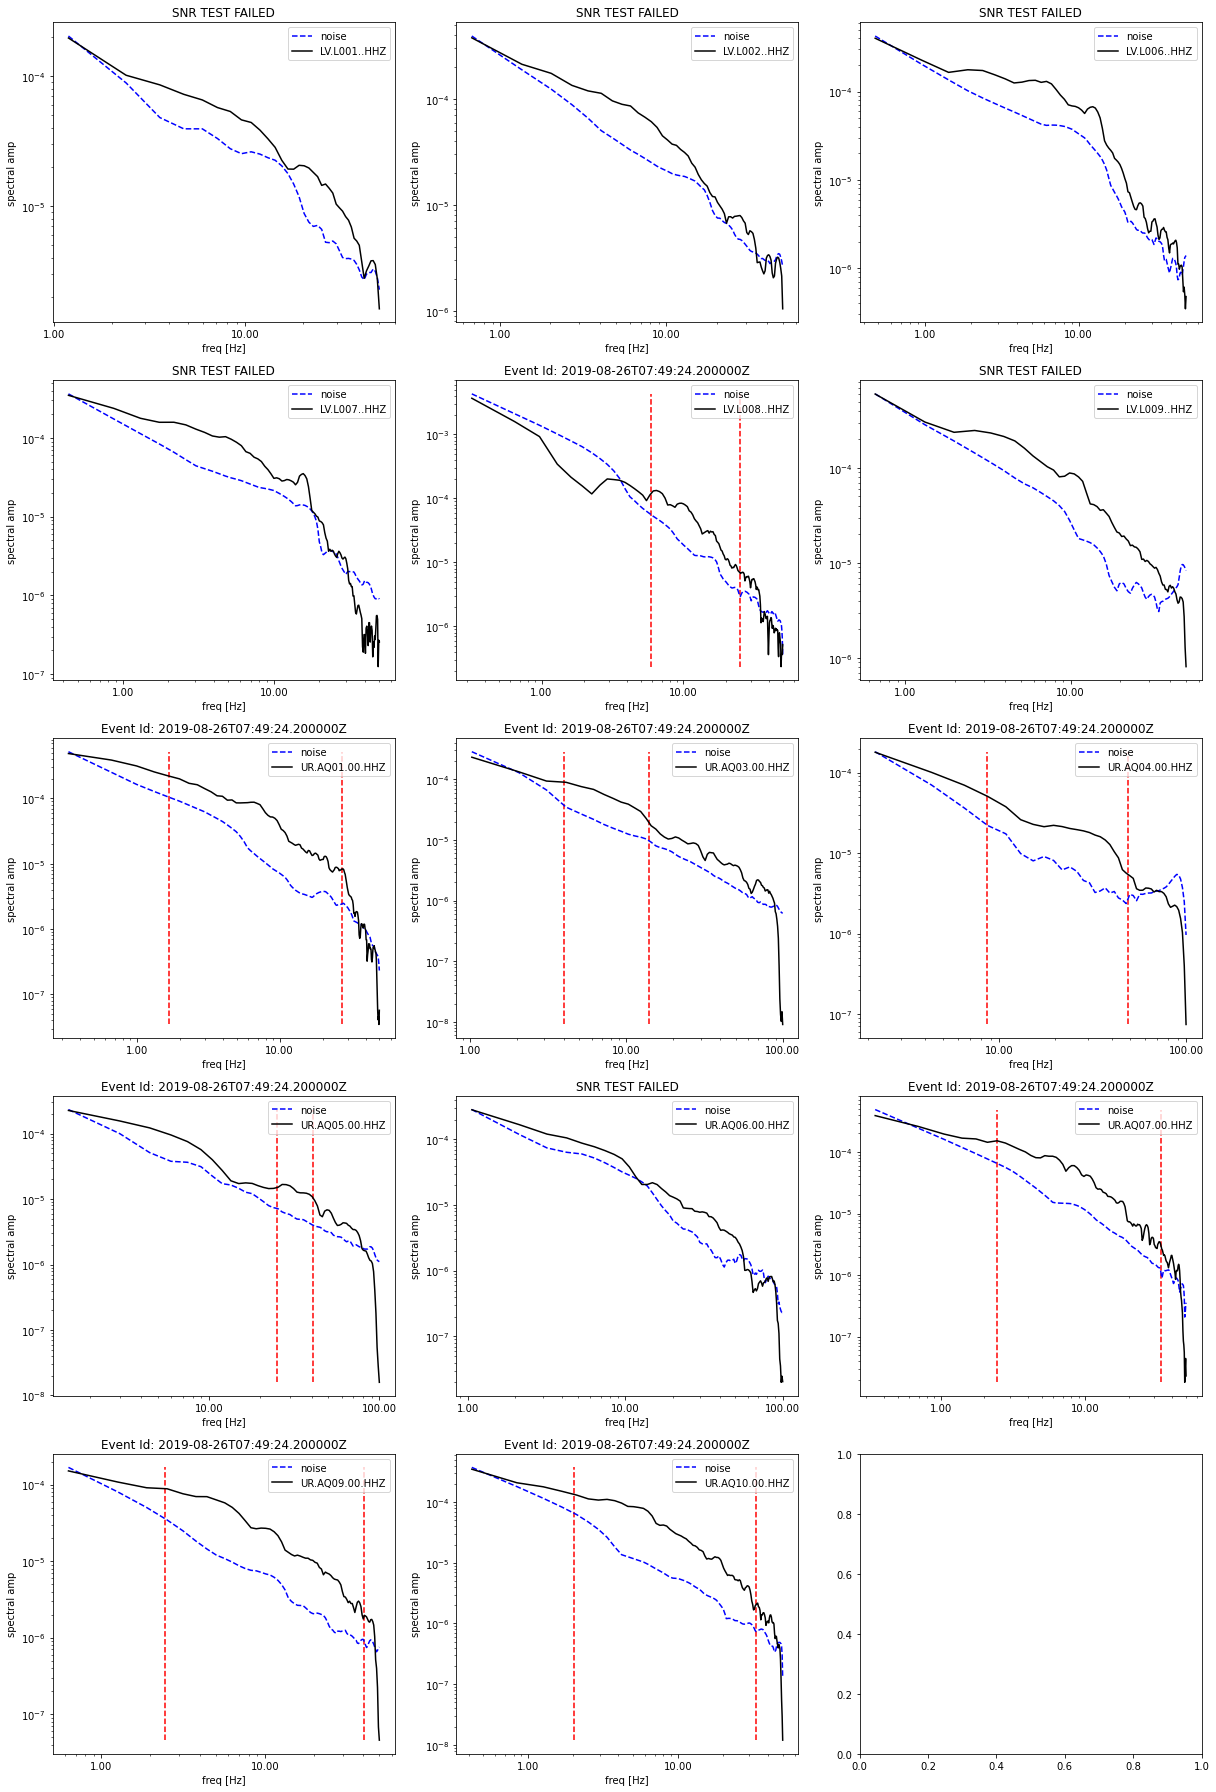

In [20]:
# you can integrate
spectra.inte()
spectra.quick_vis()

You can go back easily!

(<Figure size 1224x1800 with 15 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7feda1b346d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fed83977b50>], dtype=object))

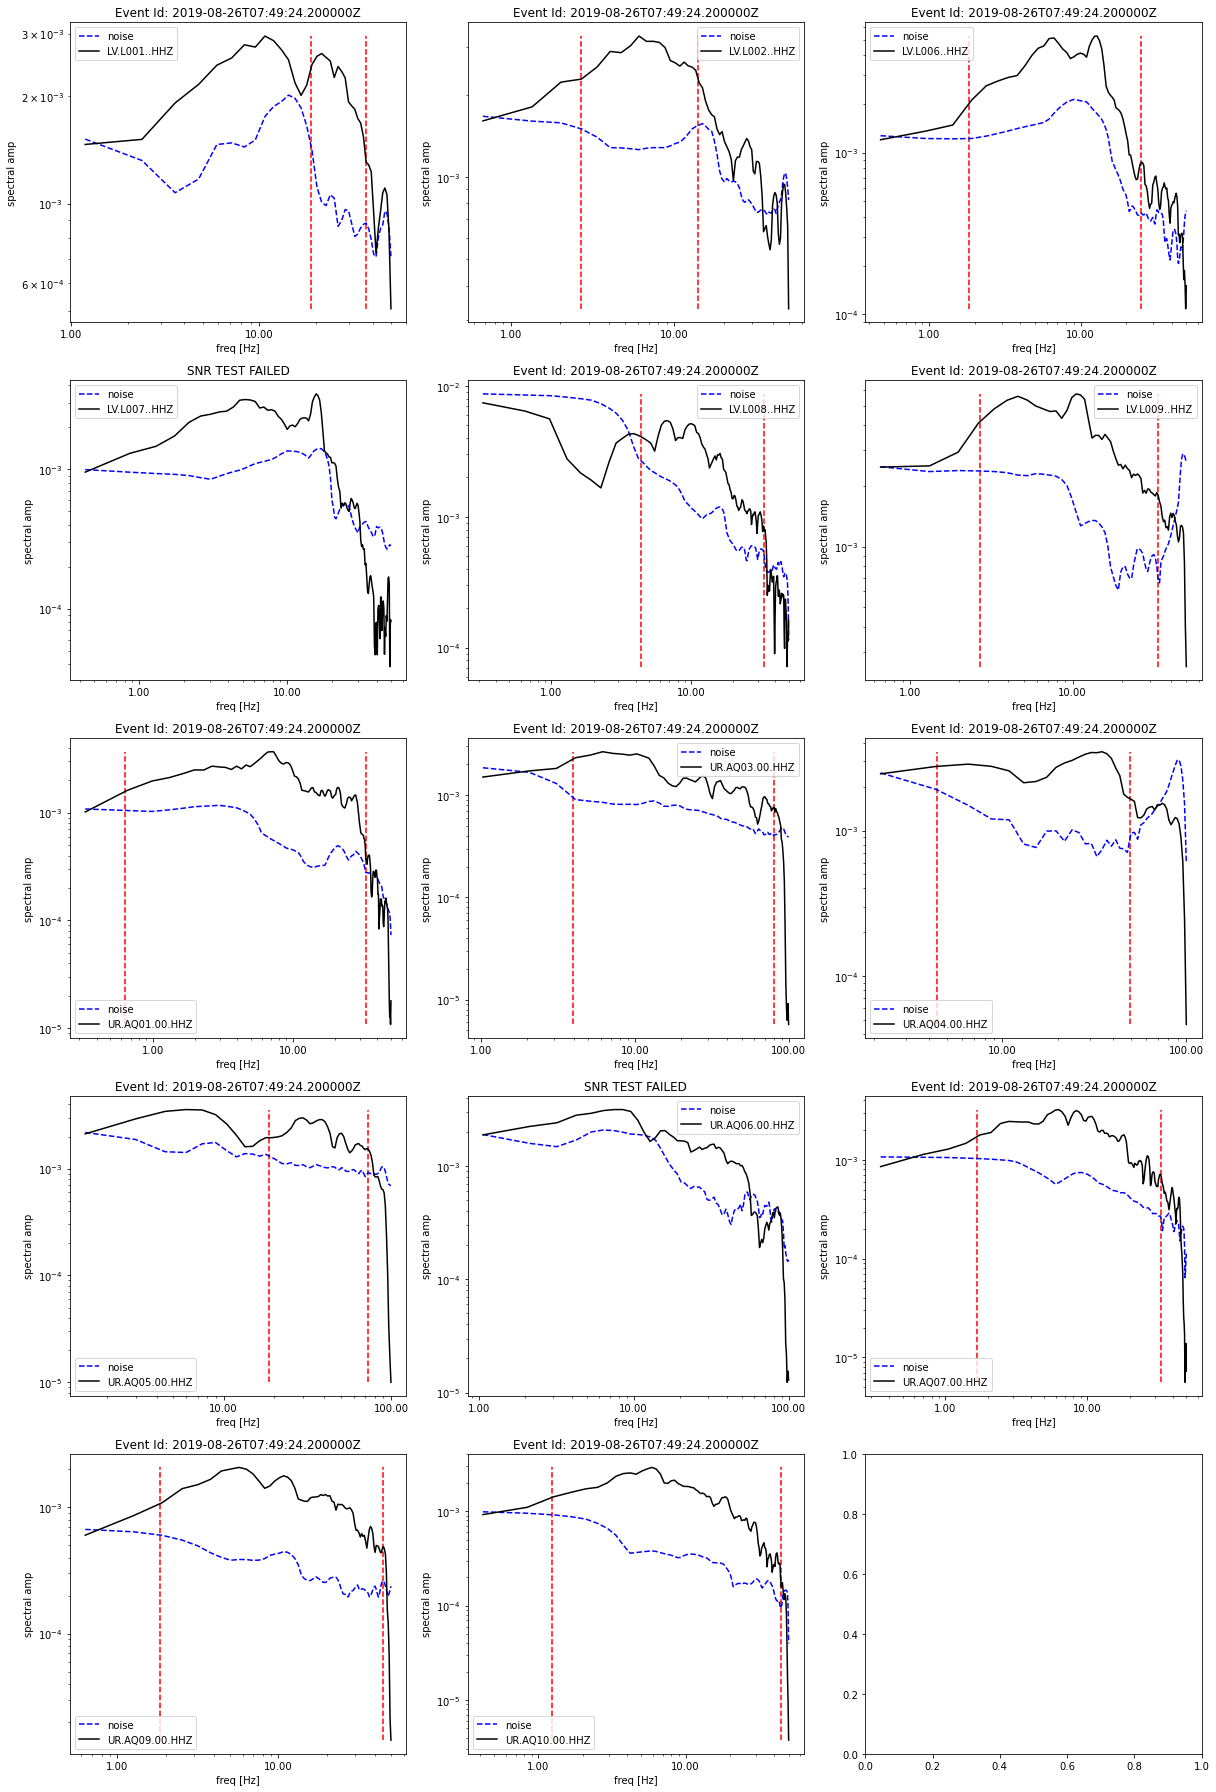

In [21]:
spectra = sp.Spectra.read_spectra(os.path.join(outpdir, "2019-08-26T07:30:47.0"+".spec"), method='pickle', skip_warning=True)
spectra.quick_vis()

# PART 3 - Modeling Spectra

## The part you've been waiting for!

In [22]:
# import the spectral module to calculate spectra from signal and noise windows
os.chdir("../")
import specmod.Fitting as fit
import specmod.Models as mod
os.chdir("Tutorial")

Spectral Fitting is a little more involved, right now only simple models can be fit:

$A(f) = \frac{{\Omega_0}} {(1+(f/f_c)^\gamma)^{\gamma n}}*\exp(-\pi f t^*)$, where the free parameters are $\Omega_0$, $f_c$ and $t^*$.

First, create a guess for those parameters for each spectrum. Conveniently, I have included a function to help you with this...


In [23]:
guess = fit.FitSpectra.create_simple_guess(spectra)

This next step will initialse the fitting process.

In [24]:
fits = fit.FitSpectra(spectra, mod.simple_model, guess)
fits.set_bounds('ts', min=0.0001) # you can set bounds for parameters (not sensible to have a ts < 0)

Then we will fit the spectra. For this we will use Powell's minimisation. 
The advantage of using the lmfit package is that it supports many search methods.
Check the docs for lmfit for more info!

In [25]:
fits.fit_spectra(method='powell')

/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/lmfit/minimizer.py:786: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/opt/anaconda3/envs/SpecMod/lib/python3.7/site-packages/lmfit/minimizer.py:779: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Visualise the fits.

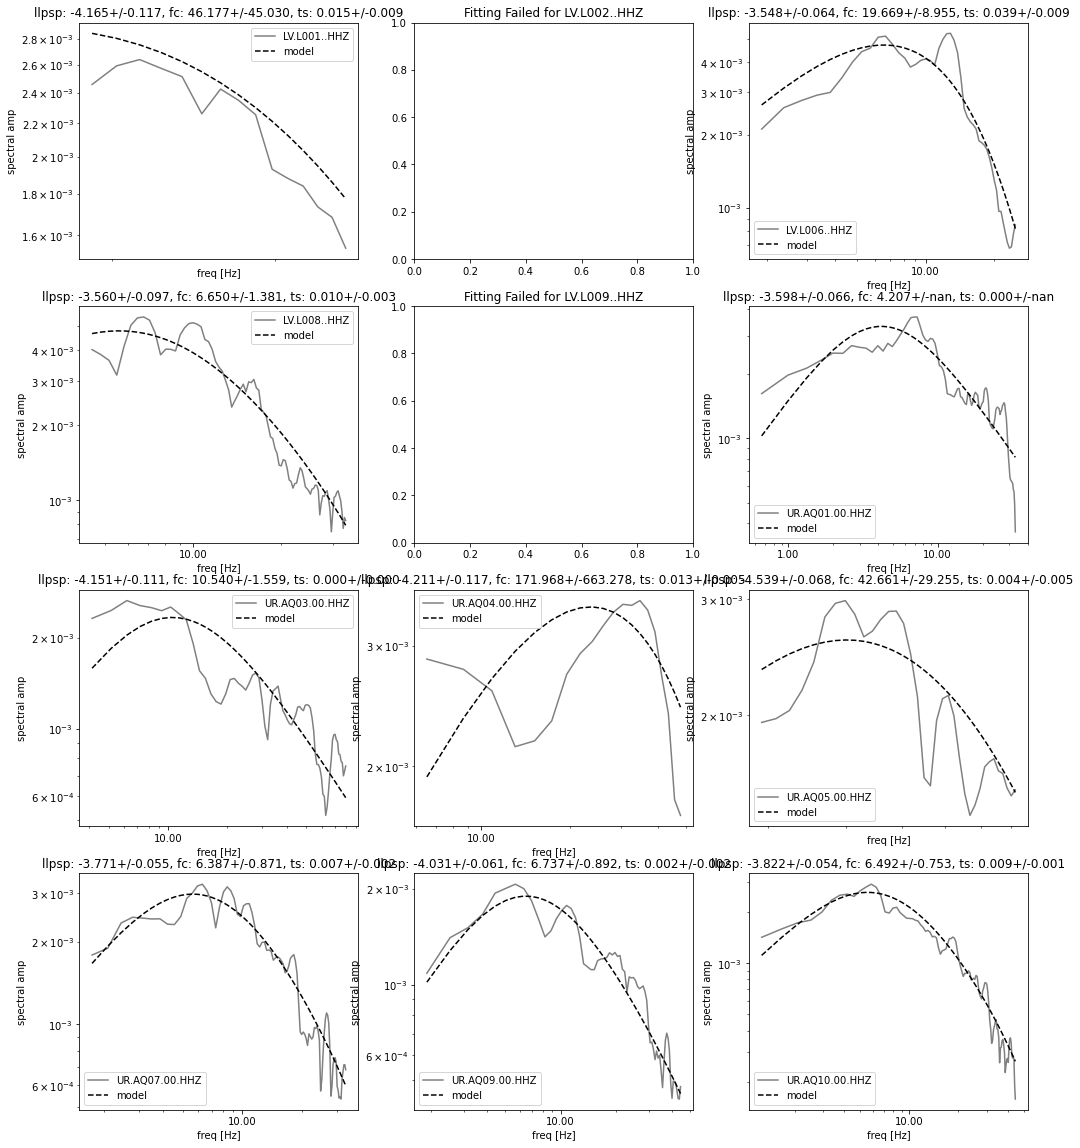

In [26]:
fits.quick_vis()

Then inspect the output!

In [27]:
fits.table

,sampling_rate,delta,starttime,endtime,npts,network,station,location,channel,mseed,...,llpsp-stderr,fc,fc-stderr,ts,ts-stderr,aic,bic,chisqr,redchi,pass_fitting
0,100.0,0.010,2019-08-26T07:30:48.730000Z,2019-08-26T07:30:49.570000Z,85,LV,L001,,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.058289,46.176723,22.514865,0.015046,0.004359,-112.778305,-110.654154,0.005459,0.000455,True
1,100.0,0.010,2019-08-26T07:30:49.760000Z,2019-08-26T07:30:51.240000Z,149,LV,L002,,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.012430,6.292408,0.154076,0.000102,0.000270,-134.831614,-132.331974,0.004292,0.000307,True
2,100.0,0.010,2019-08-26T07:30:50.120000Z,2019-08-26T07:30:52.220000Z,211,LV,L006,,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.032088,19.668513,4.477507,0.039012,0.004387,-232.690116,-227.014655,0.375534,0.008164,True
3,100.0,0.010,2019-08-26T07:30:51.850000Z,2019-08-26T07:30:54.950000Z,311,LV,L008,,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.048283,6.650493,0.690336,0.009844,0.001339,-463.814633,-456.315204,0.486581,0.005593,True
4,100.0,0.010,2019-08-26T07:30:48.710000Z,2019-08-26T07:30:50.230000Z,153,LV,L009,,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.034345,5.807766,0.422840,0.001059,0.000989,-288.706208,-283.220284,0.075925,0.001766,True
5,100.0,0.010,2019-08-26T07:30:52.230000Z,2019-08-26T07:30:55.240000Z,302,UR,AQ01,00,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.033242,4.206883,NaN,0.000242,NaN,-454.368380,-446.583020,0.946423,0.009859,True
6,200.0,0.005,2019-08-26T07:30:49.040000Z,2019-08-26T07:30:50.005000Z,194,UR,AQ03,00,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.055679,10.540171,0.779713,0.000115,0.000002,-335.024511,-328.112316,0.737585,0.010389,True
7,200.0,0.005,2019-08-26T07:30:48.110000Z,2019-08-26T07:30:48.565000Z,92,UR,AQ04,00,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.058267,171.967826,331.639133,0.012984,0.002437,-91.778288,-88.791091,0.150592,0.008858,True
8,200.0,0.005,2019-08-26T07:30:48.480000Z,2019-08-26T07:30:49.145000Z,134,UR,AQ05,00,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.033909,42.661424,14.627374,0.003562,0.002436,-193.312778,-188.562221,0.141855,0.004299,True
9,100.0,0.010,2019-08-26T07:30:51.610000Z,2019-08-26T07:30:54.470000Z,287,UR,AQ07,00,HHZ,"AttribDict({'dataquality': 'D', 'number_of_rec...",...,0.027263,6.387072,0.435606,0.007147,0.001139,-482.668964,-475.136385,0.423531,0.004813,True


Finally, save the output!

In [28]:
fits.write_flatfile(os.path.join(outpdir, "FlatFiles", fits.spectra.event + ".csv"), fits)

In [29]:
os.listdir(os.path.join(outpdir, "FlatFiles"))

['2019-08-26T07:49:24.200000Z.csv']